In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
from pandas.tseries.holiday import *
from datetime import datetime
from sklearn.model_selection import train_test_split 

In [65]:
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
import plotly.express as px

In [33]:
#Reading the data
data = pd.read_csv('Data/GlobalSuperstoreData.csv')
data.head()




,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [5]:
data.shape

(51290, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [34]:
data['Market_segment']= data['Market']+'_' +data['Segment']
data.head()

,Order Date,Segment,Market,Sales,Profit,Market_segment
0,31-07-2012,Consumer,US,2309.650,762.1845,US_Consumer
1,05-02-2013,Corporate,APAC,3709.395,-288.7650,APAC_Corporate
2,17-10-2013,Consumer,APAC,5175.171,919.9710,APAC_Consumer
3,28-01-2013,Home Office,EU,2892.510,-96.5400,EU_Home Office
4,05-11-2013,Consumer,Africa,2832.960,311.5200,Africa_Consumer


In [35]:
#Dropping columns that are not required
data_retail = data.drop(['Market','Segment'],axis=1)
data_retail.columns

Index(['Order Date', 'Sales', 'Profit', 'Market_segment'], dtype='object')

In [36]:
data_retail['Order Date'].dtype

dtype('O')

In [37]:
#Converting the Object type to Datetime type
data_retail['Order_Date'] = pd.to_datetime(data_retail['Order Date']).dt.to_period('m')

In [38]:
data_retail['Order_Date'].dtype

period[M]

In [39]:
data_profit= data_retail.pivot_table( index='Order_Date',values='Profit', columns='Market_segment' ,aggfunc='sum')
data_profit.head()

Market_segment,APAC_Consumer,APAC_Corporate,APAC_Home Office,Africa_Consumer,Africa_Corporate,Africa_Home Office,Canada_Consumer,Canada_Corporate,Canada_Home Office,EMEA_Consumer,...,EMEA_Home Office,EU_Consumer,EU_Corporate,EU_Home Office,LATAM_Consumer,LATAM_Corporate,LATAM_Home Office,US_Consumer,US_Corporate,US_Home Office
Order_Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


In [40]:
#Selecting the Market segment where CoV is minimum

mean=np.mean(data_profit)
std= np.std(data_profit)

CoV_df= pd.DataFrame(mean)
CoV_df['std']= std
CoV_df['CoV'] = std/mean
CoV_df= CoV_df.reset_index()
CoV_df.columns= ['Market_Segment', 'Mean', 'Std', 'CoV']
CoV_df.sort_values(by='CoV', ascending= True, inplace = True)
CoV_df.head()

,Market_Segment,Mean,Std,CoV
1,APAC_Corporate,2702.859058,1404.913309,0.519788
0,APAC_Consumer,4642.032508,2629.498148,0.566454
12,EU_Consumer,3930.993906,2279.300444,0.579828
15,LATAM_Consumer,2513.186082,1714.873286,0.682350
13,EU_Corporate,2570.707906,1848.968233,0.719245


In [41]:
#selecting APAC-Corporate market segment
#Converting Order date to Time stamp format
data_retail['Order_Date'] = data_retail['Order_Date'].astype(str)
data_retail['Order_Date']=pd.to_datetime(data_retail['Order_Date'])


In [42]:
data_retail= data_retail[(data_retail.Market_segment=='APAC_Corporate')]

In [43]:
data_retail.head()

,Order Date,Sales,Profit,Market_segment,Order_Date
1,05-02-2013,3709.395,-288.765,APAC_Corporate,2013-05-01
5,28-06-2013,2862.675,763.275,APAC_Corporate,2013-06-01
11,19-04-2012,4626.150,647.550,APAC_Corporate,2012-04-01
18,31-01-2014,2565.594,28.404,APAC_Corporate,2014-01-01
22,02-05-2011,2754.000,358.020,APAC_Corporate,2011-02-01


In [44]:
#Grouping the sales by Order Dates
df=pd.DataFrame(data_retail.groupby("Order_Date")['Sales'].sum())
df.head()

,Sales
Order_Date,
2011-01-01,5554.5036
2011-02-01,22817.1876
2011-03-01,18141.3765
2011-04-01,7326.6621
2011-05-01,15598.7889


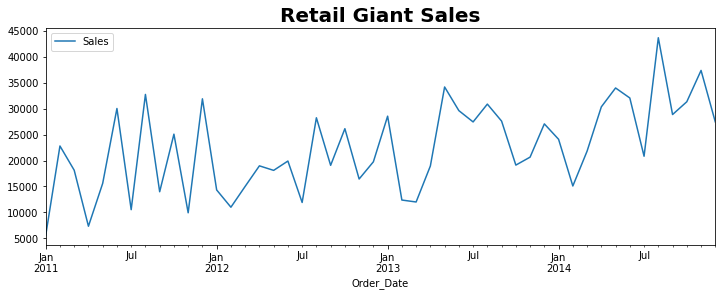

In [45]:
df.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Retail Giant Sales', fontweight='bold', size=20)
plt.show(block=False)

In [46]:
df=df.reset_index()

In [47]:
#renaming columns as per the requirements of Prohpet
df.rename(
    columns={"Sales":"y",
                "Order_Date":"ds"}
          ,inplace=True)

In [48]:
df.head()

,ds,y
0,2011-01-01,5554.5036
1,2011-02-01,22817.1876
2,2011-03-01,18141.3765
3,2011-04-01,7326.6621
4,2011-05-01,15598.7889


In [61]:
model = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df, show_progress=False)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmcbg7lp/_brxl3_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnmcbg7lp/ockqtu80.json
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:Command ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'info']
	error during processing Machine is not on the network
15:03:58 - cmdstanpy - INFO - CmdStan installation /usr/local/lib/python3.8/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
INFO:cmdstanpy:CmdStan installation /usr/local/lib/python3.8/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
15:03:58 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
INFO:

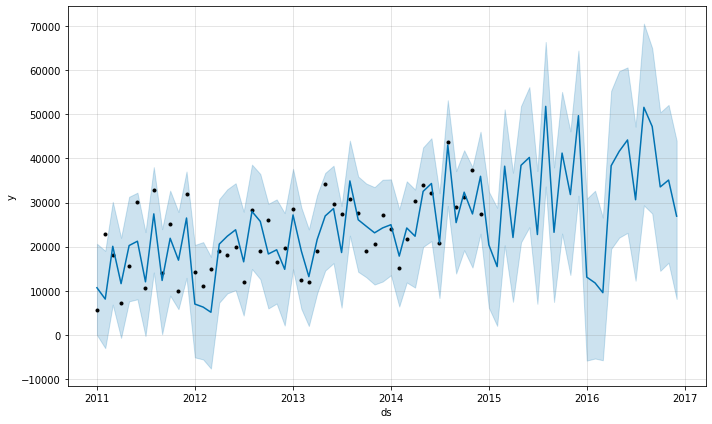

In [63]:
future = model.make_future_dataframe(periods=24, freq='MS')
fcst = model.predict(future)
fig = model.plot(fcst)

In [70]:
len(df)


48